In [ ]:
!pip install pandas nltk sklearn matplotlib seaborn transformers


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha() and word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)


In [ ]:
# from google.colab import files
# uploaded = files.upload()
df = pd.read_csv('/content/balanced_customer_feedback_v2.csv')
df['cleaned_review'] = df['review'].apply(preprocess_text)


In [ ]:
df

,review,sentiment,cleaned_review
0,The user interface is very nice and easy to us...,1,user interface nice easy use satisfied purchase
1,The product works as advertised. It's reliable...,1,product work advertised reliable performs well...
2,Fantastic product! It has significantly improv...,1,fantastic product significantly improved daily...
3,"Shipping was fast, and the item arrived in per...",1,shipping fast item arrived perfect condition h...
4,I'm extremely happy with the performance. It e...,1,extremely happy performance exceeded expectati...
...,...,...,...
245,I had a terrible experience with the customer ...,0,terrible experience customer support team unhe...
246,I received the wrong item and had to go throug...,0,received wrong item go lengthy return process ...
247,The build quality is subpar. It feels cheap an...,0,build quality subpar feel cheap flimsy sure la...
248,The instructions were unclear and hard to foll...,0,instruction unclear hard follow struggled get ...


In [ ]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 3))
X = vectorizer.fit_transform(df['cleaned_review'])
y = df['sentiment']

/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



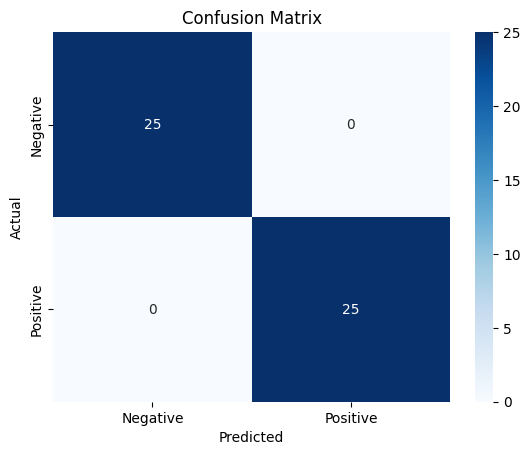

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create the model
model = LogisticRegression(max_iter=2000)

# More extensive hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
    'class_weight': [None, 'balanced']
}
grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# Best model
best_model = grid.best_estimator_

# Calibrate the model
calibrated_model = CalibratedClassifierCV(base_estimator=best_model, method='isotonic')
calibrated_model.fit(X_train, y_train)

# Evaluate the model
y_pred = calibrated_model.predict(X_test)
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The sentiment of the feedback is Neutral with a score of 0.51.


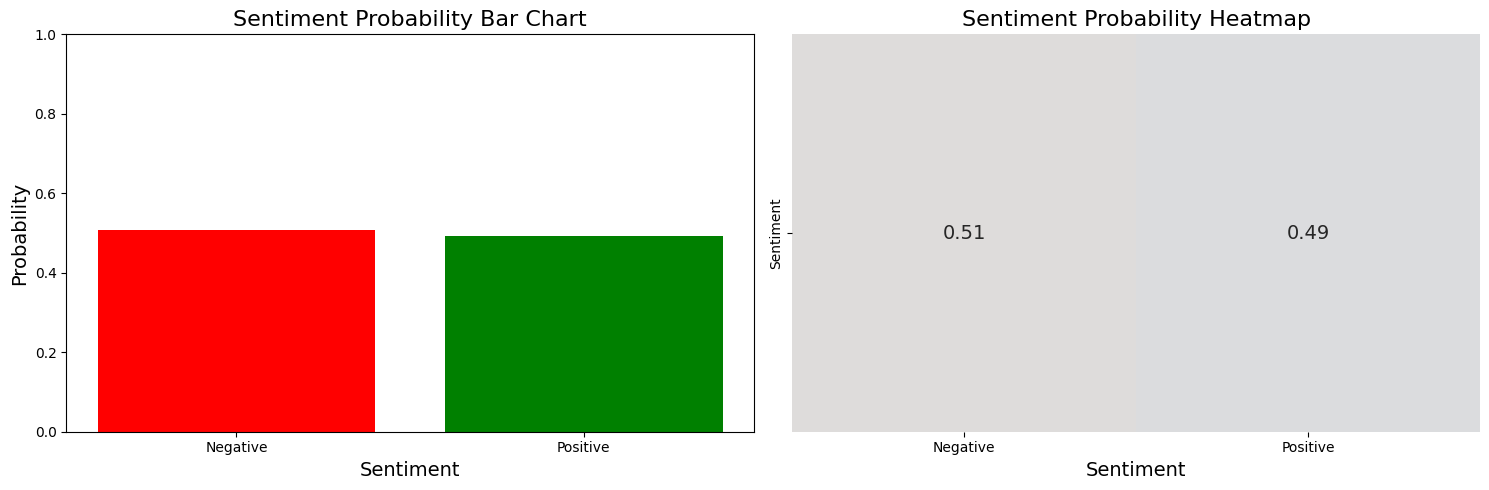

The sentiment of the feedback is Negative with a score of 0.67.


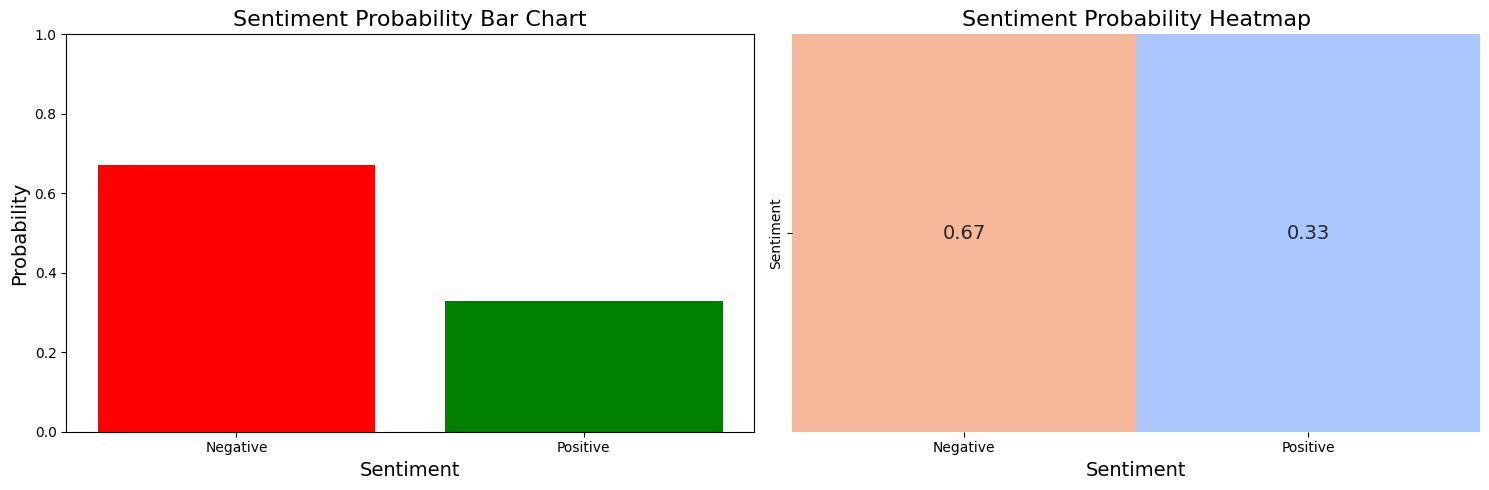

The sentiment of the feedback is Negative with a score of 0.58.


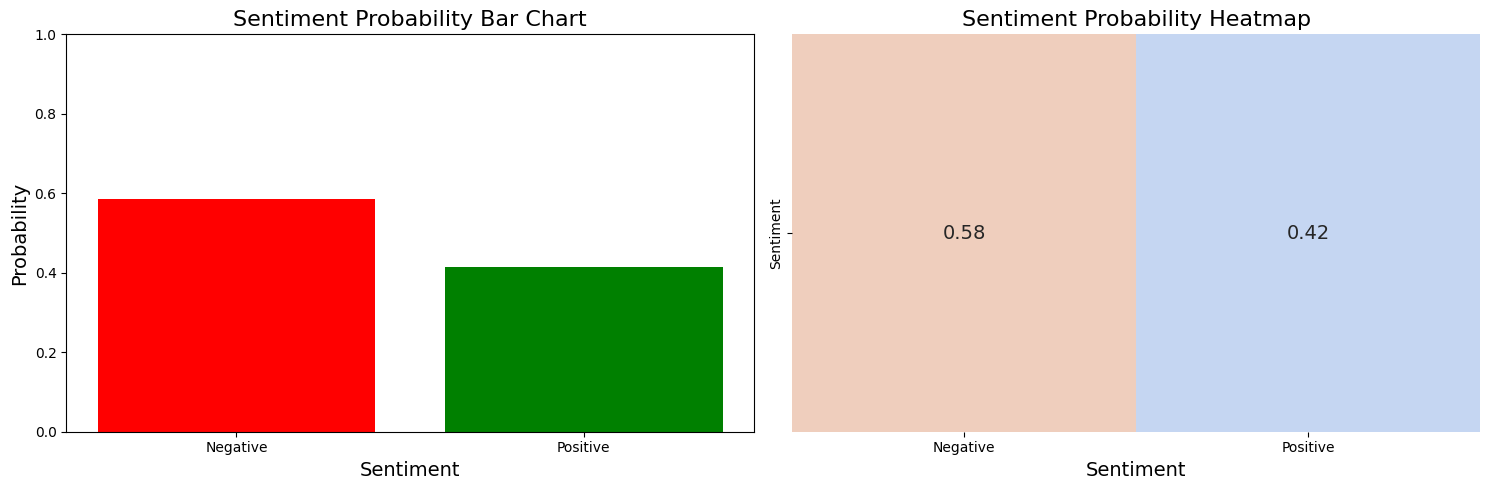

The sentiment of the feedback is Positive with a score of 0.63.


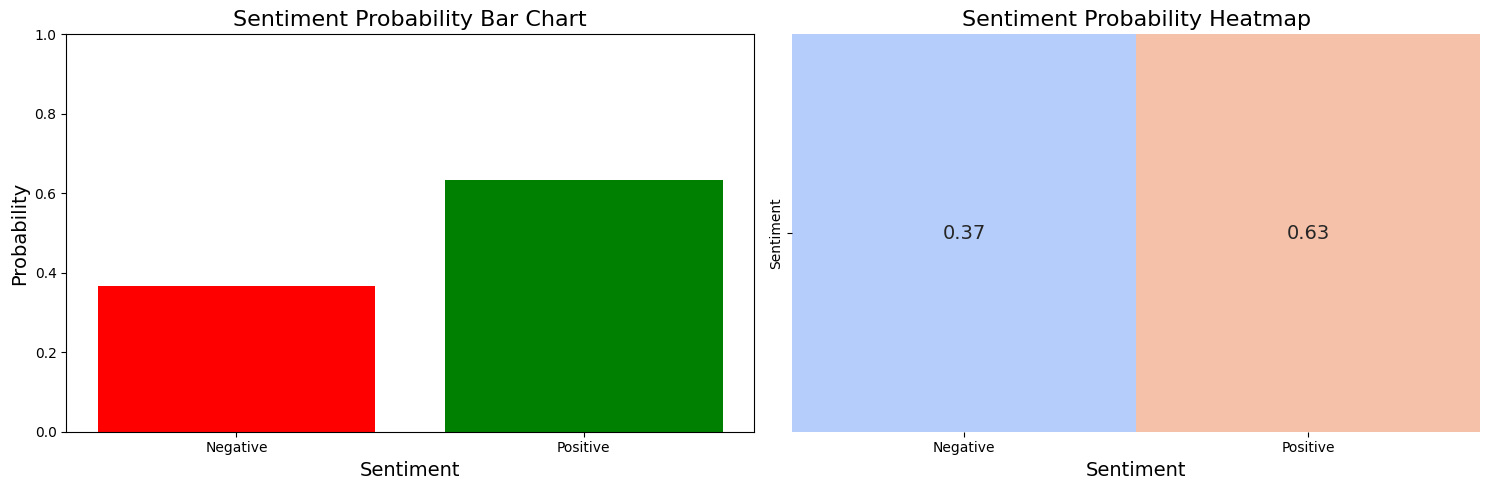

The sentiment of the feedback is Positive with a score of 0.70.


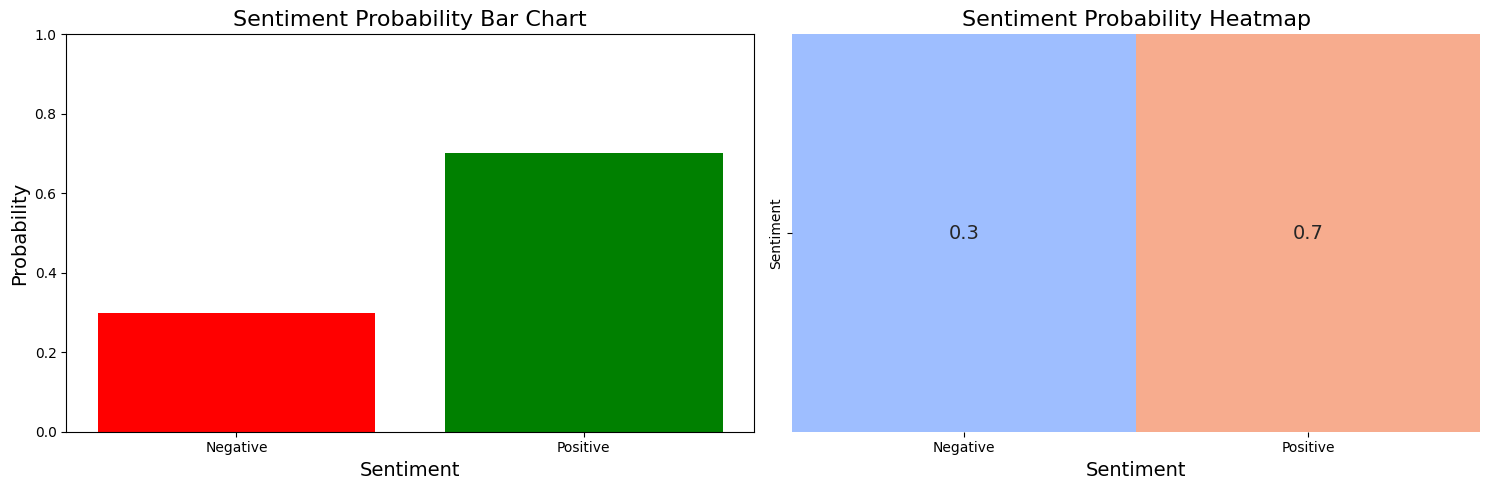

The sentiment of the feedback is Neutral with a score of 0.52.


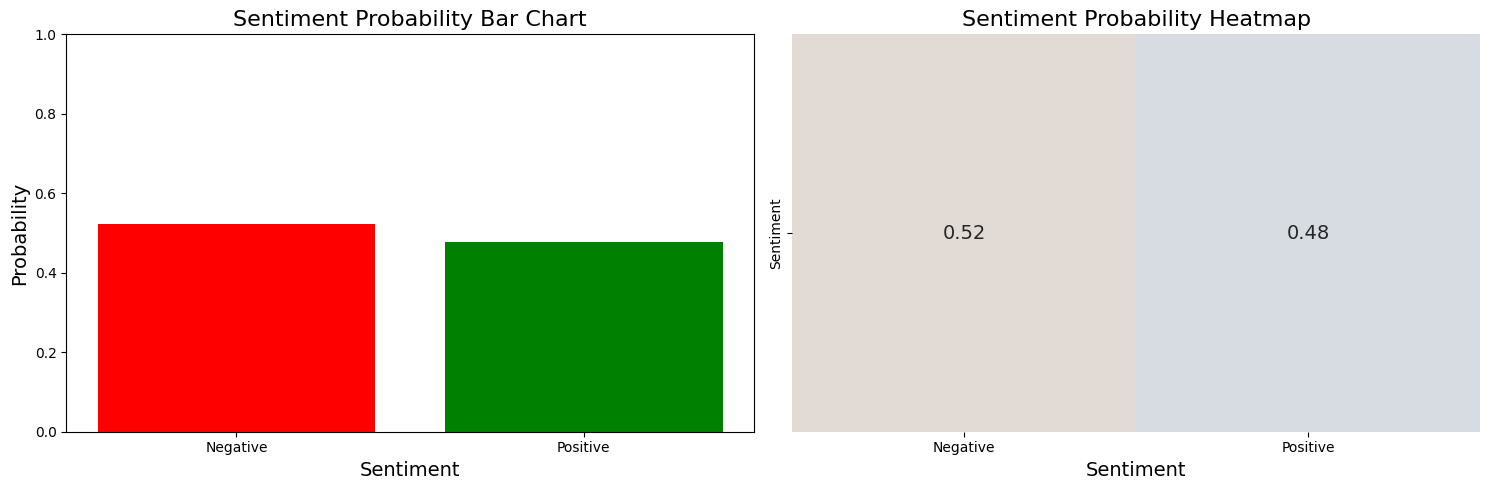

The sentiment of the feedback is Negative with a score of 0.61.


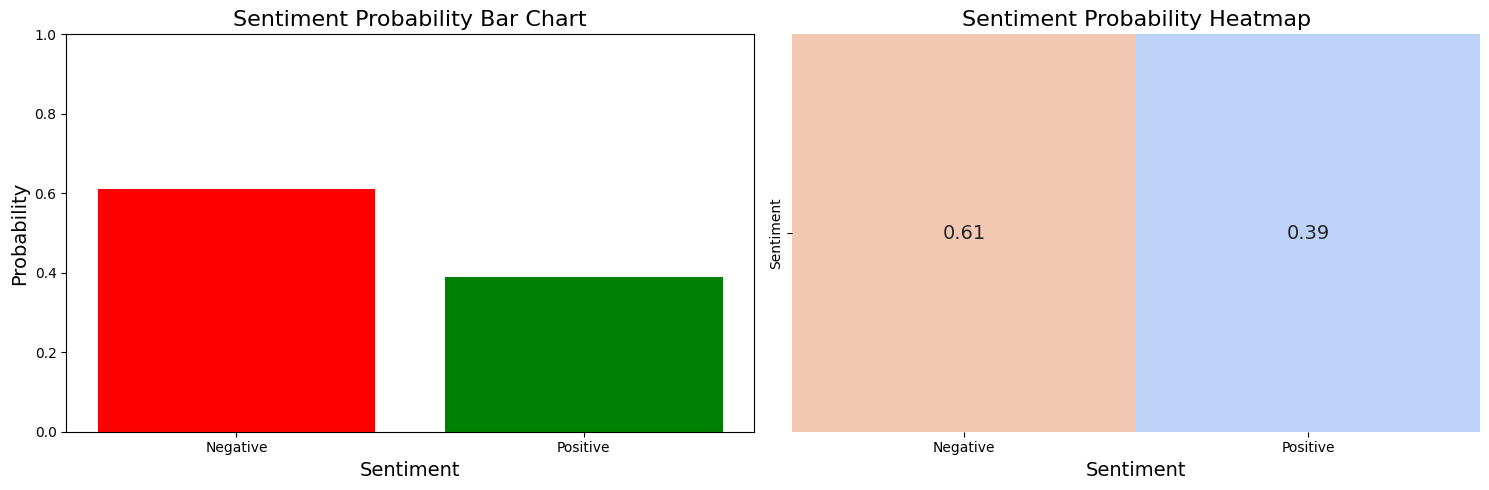

The sentiment of the feedback is Negative with a score of 0.64.


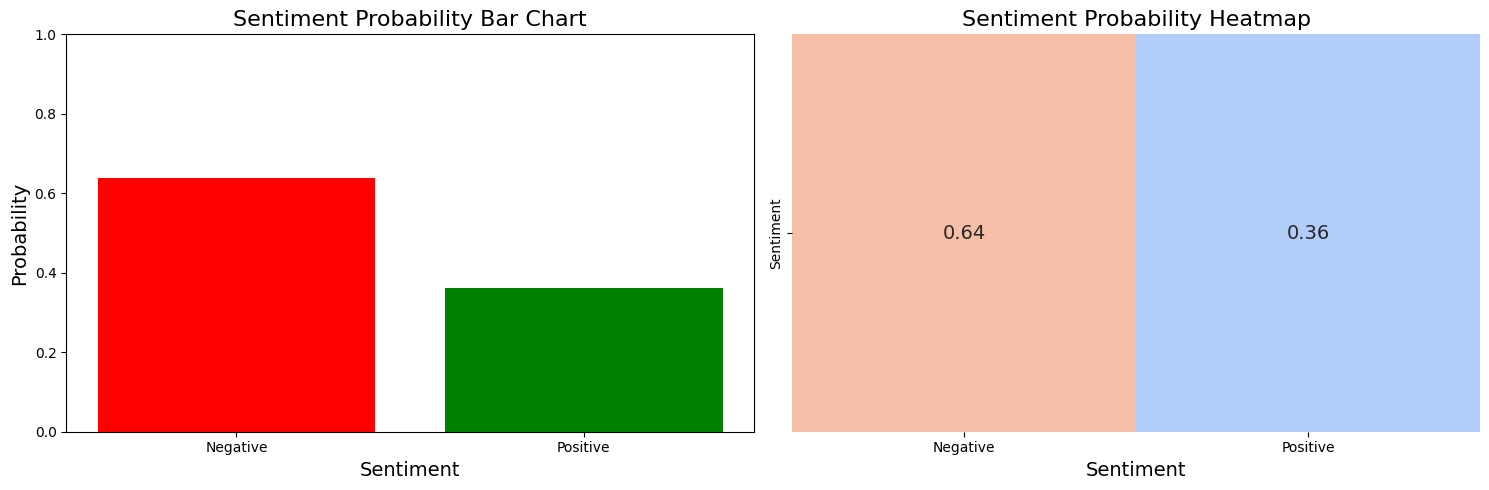

The sentiment of the feedback is Positive with a score of 0.75.


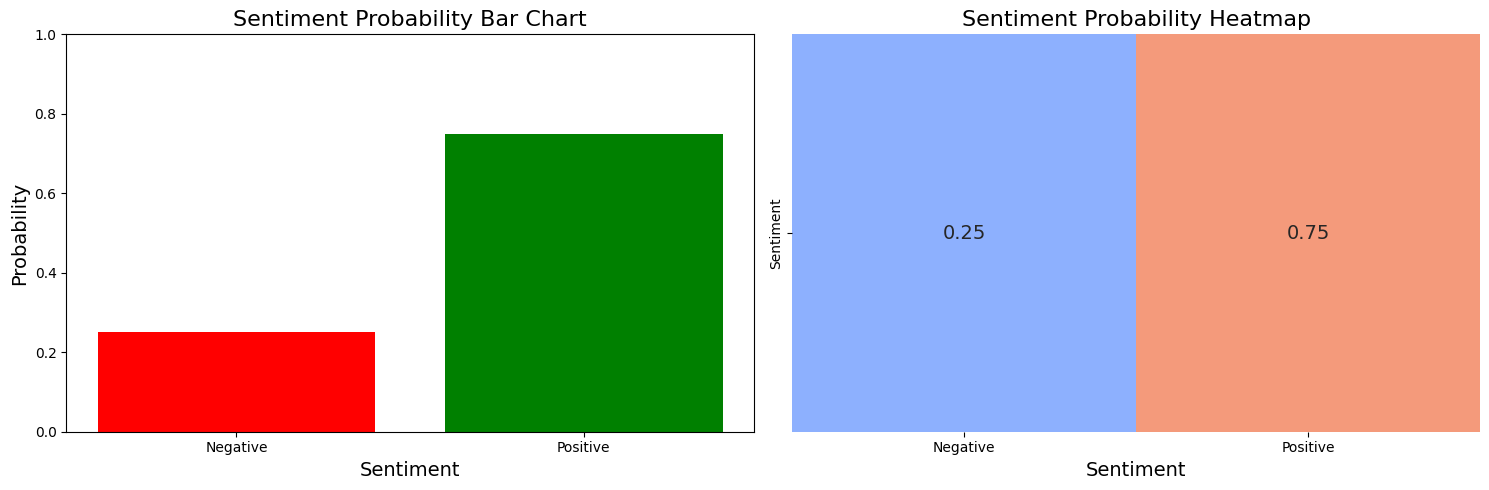

The sentiment of the feedback is Positive with a score of 0.58.


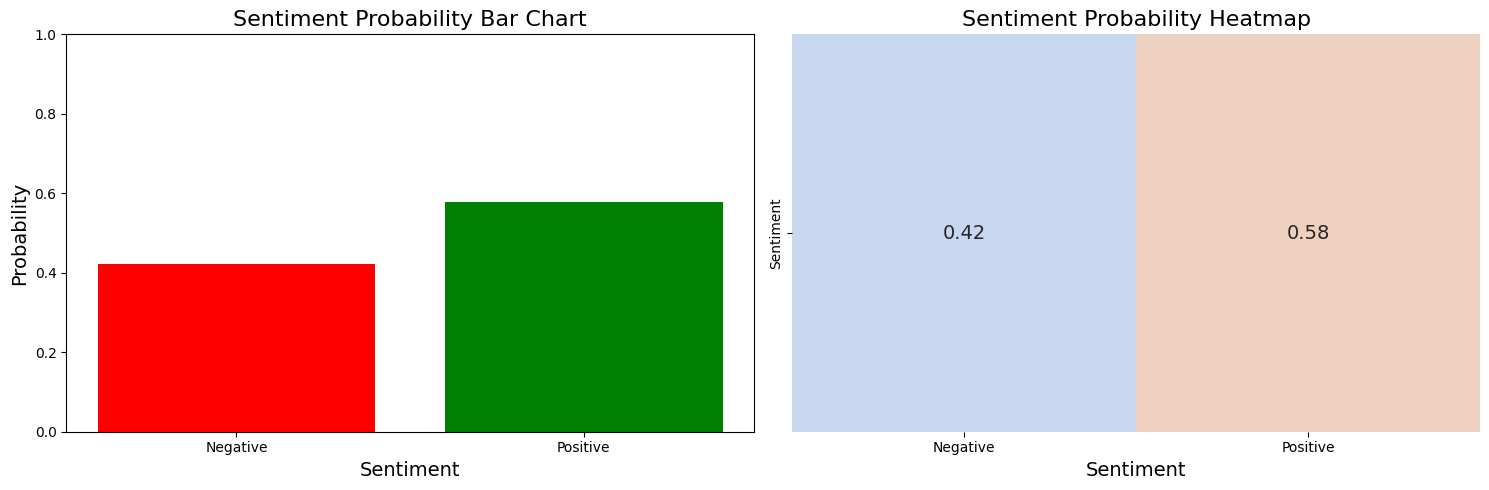

The sentiment of the feedback is Positive with a score of 0.77.


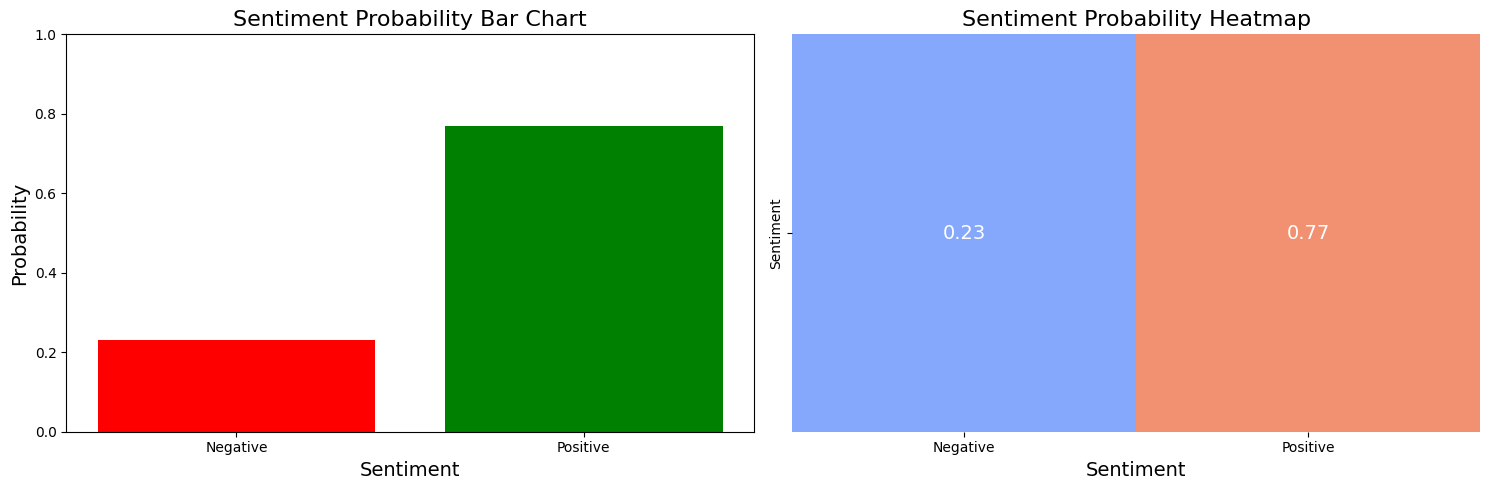

In [ ]:
def preprocess_and_vectorize(text):
    cleaned_text = preprocess_text(text)
    return vectorizer.transform([cleaned_text])

def analyze_sentiment_logreg(user_input):
    X_input = preprocess_and_vectorize(user_input)
    predicted_proba = calibrated_model.predict_proba(X_input)

    negative_score = predicted_proba[0][0]
    positive_score = predicted_proba[0][1]

    if positive_score < 0.55 and negative_score < 0.55:
        sentiment_label_str = 'Neutral'
        sentiment_score = max(positive_score, negative_score)
    else:
        sentiment_label_str = 'Positive' if positive_score >= negative_score else 'Negative'
        sentiment_score = max(positive_score, negative_score)

    print(f"The sentiment of the feedback is {sentiment_label_str} with a score of {sentiment_score:.2f}.")

    # Create a bar chart and a heatmap side by side
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    bars = ['Negative', 'Positive']
    scores = [negative_score, positive_score]
    axes[0].bar(bars, scores, color=['red', 'green'])
    axes[0].set_title('Sentiment Probability Bar Chart', fontsize=16)
    axes[0].set_xlabel('Sentiment', fontsize=14)
    axes[0].set_ylabel('Probability', fontsize=14)
    axes[0].set_ylim(0, 1)

    heatmap_data = np.array([scores])
    sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', xticklabels=bars, yticklabels=['Sentiment'], vmin=0, vmax=1, cbar=False, annot_kws={"size": 14}, ax=axes[1])
    axes[1].set_title('Sentiment Probability Heatmap', fontsize=16)
    axes[1].set_xlabel('Sentiment', fontsize=14)
    axes[1].set_ylabel('', fontsize=14)

    plt.tight_layout()
    plt.show()


# Example user inputs for testing
reviews = [
    "I absolutely love this product!But Bad customer service ",
    "Absolutely horrible experience. The product was defective, customer service was rude, and I wasted my money. Will never buy from this company again. Total disaster.",
    "The product is okay. It has some good features, but there are a few flaws that need to be addressed. Overall, it's decent but not exceptional.",
    "The product arrived on time and was as described. It does what it's supposed to do, but there's nothing particularly outstanding about it. It's an average product.",
    "This is the best purchase I've made in a long time. Everything works perfectly and I'm extremely satisfied.",
    "Uncomment and add more reviews if needed",
    "Terrible quality. The product broke after just one use. Very disappointed.",
    "The item is neither great nor bad. It's just alright and gets the job done.",
    "Good value for the money. Satisfied with the purchase.",
    "The product is not what I expected. It's below average.",
    "Fast shipping and great packaging. The product itself is decent and works well."
]

reviews2 = [
    "The user interface is very nice and easy to use. I'm very satisfied with this purchase.",
    "I had a terrible experience with the customer support team. They were unhelpful and rude.",
    "The product works as advertised. It's reliable and performs well under different conditions.",
    "I received the wrong item and had to go through a lengthy return process. Very disappointed.",
    "Fantastic product! It has significantly improved my daily routine and productivity.",
    "The build quality is subpar. It feels cheap and flimsy, and I'm not sure it will last long.",
    "Shipping was fast, and the item arrived in perfect condition. I'm very happy with the service.",
    "The instructions were unclear and hard to follow. I struggled to get it set up properly.",
    "I'm extremely happy with the performance. It exceeded my expectations in every way.",
    "The product does not match the description. It's missing several features that were promised."
]

for review in reviews:
    analyze_sentiment_logreg(review)

# Uncomment to get user feedback input
# user_feedback = input("Enter your feedback: ")
# analyze_sentiment_logreg(user_feedback)
